# Setups, Installations and Imports

This loss landscape analysis for MIMO is originally borrowed from the paper *Deep Ensembles: A Loss Landscape Perspective* by Fort et. al.
Code is available here: https://github.com/ayulockin/LossLandscape


In [ ]:
!nvidia-smi

Wed Dec  8 16:14:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
## This is so that I can save my models.
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras.applications import resnet50


In [ ]:
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import io
import itertools
from sklearn.metrics import confusion_matrix

# Download and Prepare Dataset

#### MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

CLASS_NAMES = ("0", "1", "2", "3", "4", "5", "6", "7", "8", "9")
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


#### Dataloader

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128
IMG_SHAPE = 28 # 28 for MNIST and 32 for CIFAR-10
M = 3
tf.random.set_seed(1)

# For MNIST: 
# reshape to fit to model. Add dim for the 1 color channel
x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=1)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=1)
# Remove some datapoints to make sets divisable by 3 (so that all batches have size 3)
x_test = x_test[:9999,:,:,:]
y_test = y_test[:9999,:]

trainloader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def preprocess_image(image, label):
  img = tf.cast(image, tf.float32)
  img = img/255.

  return img, label

def tile_image(image, label):
  print(label.shape)
  labels_tiled = tf.tile(tf.expand_dims(label, 2), [1, M,1])
  images = tf.tile(tf.expand_dims(image, 1), [1, M, 1, 1, 1])
  images = tf.squeeze(images, axis=0)
  label = tf.squeeze(labels_tiled, axis=0)
  return images,label

trainloader_1 = (
    trainloader
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(3)
    .prefetch(AUTO)
)
trainloader = (
    trainloader_1
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader_1 = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(1) # tried drop_remainder=True
    .prefetch(AUTO)
)

testloader = (
    testloader_1
    .map(tile_image)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

(None, 1)


# Model

In [ ]:
# Dense multihead for multiple outputs, as Implemented in the MIMO paper.
# Here applied to the Loss Landscape analysis
# coding=utf-8
# Copyright 2020 The <> Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

class DenseMultihead(tf.keras.layers.Dense):
    """Multiheaded output layer."""

    def __init__(self,
                 units,
                 ensemble_size=1,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        super().__init__(
            units=units * ensemble_size,
            activation=activation,
            use_bias=use_bias,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            activity_regularizer=activity_regularizer,
            kernel_constraint=kernel_constraint,
            bias_constraint=bias_constraint,
            **kwargs)
        self.ensemble_size = ensemble_size

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # NOTE: This restricts this layer from being called on tensors of ndim > 2.
        outputs = super().call(inputs)
        outputs = tf.reshape(outputs, [batch_size,
                                       self.ensemble_size,
                                       self.units // self.ensemble_size])
        return outputs

    def get_config(self):
        config = {
            'units': self.units // self.ensemble_size,
            'ensemble_size': self.ensemble_size,
        }
        new_config = super().get_config()
        new_config.update(config)
        return new_config

In [ ]:
# Modified model to use the MIMO architecture
def Model():
  """
  Code from the mimo implementation
  input_shape: tf.Tensor. The input shape must be (ensemble_size, width,
      height, channels).
  """
  num_classes = 10
  ensemble_size = 3
  input_shape = list([3, IMG_SHAPE, IMG_SHAPE, 1])
  inputs = tf.keras.layers.Input(shape=input_shape)
  x = tf.keras.layers.Permute([2, 3, 4, 1])(inputs)
  if ensemble_size != input_shape[0]:
      raise ValueError('the first dimension of input_shape must be ensemble_size')
  x = tf.keras.layers.Reshape(input_shape[1:-1] +
                                [input_shape[-1] * ensemble_size])(x)


  x = keras.layers.Conv2D(16, (3,3), padding='same')(x)
  x = keras.activations.relu(x)
  x = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1))(x) # Tried with 1

  x = keras.layers.Conv2D(32,(3,3), padding='same')(x)
  x = keras.activations.relu(x)
  x = keras.layers.MaxPooling2D(2, strides=2)(x)

  x = keras.layers.Conv2D(32,(3,3), padding='same')(x)
  x = keras.activations.relu(x)
  x = keras.layers.MaxPooling2D(2, strides=2)(x)

  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(32, activation='relu')(x)
  x = keras.layers.Dropout(0.1)(x)
  
  # outputs = keras.layers.Dense(10, activation='softmax')(x)
  """
  Outputs as prensented in the MIMO paper (taken from their implementation)
  """
  outputs = DenseMultihead(
        num_classes,
        kernel_initializer='he_normal', # TODO: check this! what should this be?
        activation='softmax', # this is changed from the MIMO implementation
        ensemble_size=ensemble_size)(x)

  return keras.models.Model(inputs=inputs, outputs=outputs)

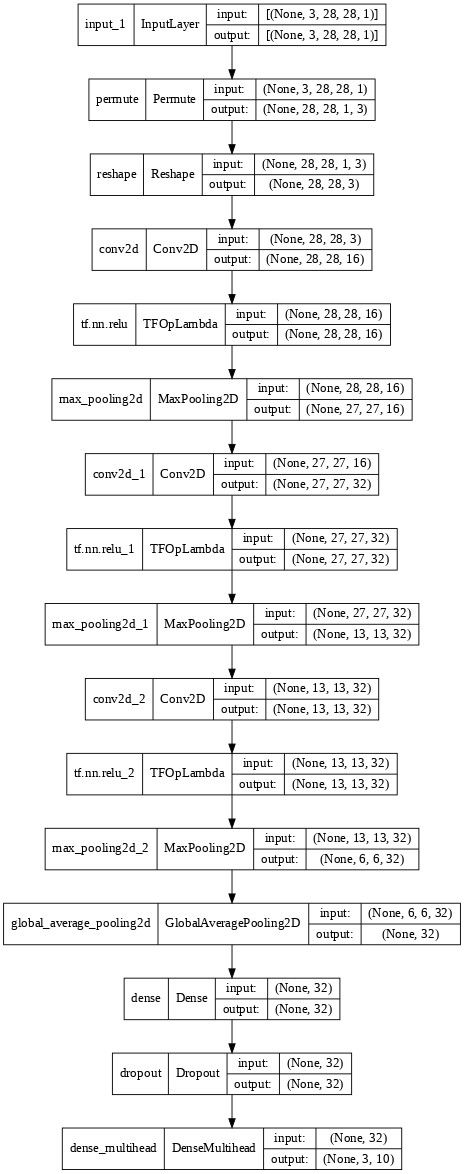

In [ ]:
tf.keras.backend.clear_session()
model = Model()

tf.keras.utils.plot_model(
    model, to_file='small_cnn.png', show_shapes=True, show_layer_names=True, dpi=65
)

# Callbacks

#### LR Scheduler

In [ ]:
# Custom LR schedule as mentioned in the LossLandscape paper
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1.6*1e-3),
    (9, (1.6*1e-3)/2),
    (19, (1.6*1e-3)/4),
    (29, (1.6*1e-3)/8),
]

def lr_schedule(epoch):
    if (epoch >= 0) & (epoch < 9):
        return LR_SCHEDULE[0][1]
    elif (epoch >= 9) & (epoch < 19):
        return LR_SCHEDULE[1][1]
    elif (epoch >= 19) & (epoch < 29):
        return LR_SCHEDULE[2][1]
    else:
        return LR_SCHEDULE[3][1]

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

#### Model Checkpoint

In [ ]:
SAVE_PATH = 'gdrive/My Drive/Colab Notebooks/DD2412/LossLandscape/OK_TEST_MNIST_SmallCNN_CheckpointID_1/'

In [ ]:
def save_model(epoch, logs):
  model.save(SAVE_PATH+'small_cnn_checkpoint_{}.tf'.format(epoch))

save_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=save_model, verbose=True)

# Initialize Model

In [ ]:
keras.backend.clear_session()
model = Model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 28, 28, 1)]    0         
                                                                 
 permute (Permute)           (None, 28, 28, 1, 3)      0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 16)       0         
 )                                                               
                                                             

# Compile

In [ ]:
model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Train

In [ ]:
EPOCHS = 40

start = time.time()
print(trainloader)
print(testloader)
_ = model.fit(trainloader,
          epochs=EPOCHS,
          validation_data=testloader,
          callbacks=[lr_callback,
                     save_callback])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
# wandb.log({'training_time': end - start})
# wandb.log({'nb_model_params': model.count_params()})

<PrefetchDataset shapes: ((None, None, 28, 28, 1), (None, None, 1)), types: (tf.float32, tf.uint8)>
<PrefetchDataset shapes: ((None, 3, 28, 28, 1), (None, 3, 1)), types: (tf.float32, tf.uint8)>

Epoch 00001: LearningRateScheduler setting learning rate to 0.0016.
Epoch 1/40
157/157 [==============================] - 21s 68ms/step - loss: 2.2078 - accuracy: 0.1767 - val_loss: 2.3279 - val_accuracy: 0.1005 - lr: 0.0016

Epoch 00002: LearningRateScheduler setting learning rate to 0.0016.
Epoch 2/40
157/157 [==============================] - 9s 59ms/step - loss: 2.0280 - accuracy: 0.2522 - val_loss: 2.2520 - val_accuracy: 0.1770 - lr: 0.0016

Epoch 00003: LearningRateScheduler setting learning rate to 0.0016.
Epoch 3/40
157/157 [==============================] - 11s 67ms/step - loss: 1.8216 - accuracy: 0.3274 - val_loss: 1.9492 - val_accuracy: 0.2723 - lr: 0.0016

Epoch 00004: LearningRateScheduler setting learning rate to 0.0016.
Epoch 4/40
157/157 [==============================] - 10s 61

NameError: ignored

# Evaluate

In [ ]:
loss, accuracy = model.evaluate(testloader, callbacks=[WandbCallback()])
print("Test Error Rate: ", round((1-accuracy)*100, 2), '%')
wandb.log({'Test Error Rate': round((1-accuracy)*100, 2)})

27/27 [==============================] - 1s 20ms/step - loss: 0.7011 - accuracy: 0.7715
Test Error Rate:  22.85 %


# Investigating Load Landscape

In [ ]:
# Load the model! - this directory contain folders of the model at each epoch
ROOT_PATH = 'gdrive/My Drive/Colab Notebooks/DD2412/LossLandscape/'
## SmallCNN model checkpoint for each epoch(total 40 epochs)
MODEL_PATH = ROOT_PATH+'OK_TEST_MNIST_SmallCNN_CheckpointID_1/'
same_model_ckpts = os.listdir(MODEL_PATH)
print(len(same_model_ckpts))

40


In [ ]:
# sort the models
# https://stackoverflow.com/a/2669120/7636462
import re 

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

same_model_ckpts = sorted_nicely(same_model_ckpts)
same_model_ckpts[:5]

['small_cnn_checkpoint_0.tf',
 'small_cnn_checkpoint_1.tf',
 'small_cnn_checkpoint_2.tf',
 'small_cnn_checkpoint_3.tf',
 'small_cnn_checkpoint_4.tf']

In [ ]:
NUM_EXAMPLES = 1024
NUM_CLASSES = 10
test_tsne_ds = testloader.unbatch().take(NUM_EXAMPLES).batch(BATCH_SIZE)

In [ ]:
# Given model and test data, return true_labels and predictions.
def evaluate_tsne(test_dataloader, model):
  true_labels = []
  pred_labels = []
  
  for imgs, labels in iter(test_dataloader):
    preds = model.predict(imgs)
    # preds will be a 3 x 10 array (128 x 3 x 10)
    # labels will be 3 x 1 array ? (128 x 3 x 1)
    
    true_labels.extend(labels)
    pred_labels.extend(preds) ## change here 
  
  # Shape of the returned values: (1024, 3, 1) alt (1024, 3, 10) 

  return np.array(true_labels), np.array(pred_labels)

In [ ]:
NUM_TRAJECTORIES = 3 # This is now instead used for the number of subnetworks

predictions_for_tsne = []

model_files = same_model_ckpts
predictions_1 = []
predictions_2 = []
predictions_3 = []
for model_file in model_files:
  if model_file=='small_cnn_checkpoint_5.tf': # this check is because this model checkpoint didn't serialize properly.
    continue
  model = tf.keras.models.load_model(MODEL_PATH+'/'+model_file)

  _, preds = evaluate_tsne(test_tsne_ds, model)

  # ADDED: subdivide into predictions of the 3 subnetworks
  # Shape: (1024, 3, 10) -> 3 x (1024, 10)
  preds_arr = []
  for i in range(3):
    preds_curr = preds[:, i:i+1, :]
    preds_curr = np.reshape(preds_curr, (1024, 10))
    if i is 0:
      predictions_1.append(preds_curr)
    elif i is 1:
      predictions_2.append(preds_curr)
    else:
      predictions_3.append(preds_curr)


predictions_1 = np.array(predictions_1)
predictions_2 = np.array(predictions_2)
predictions_3 = np.array(predictions_3)
print(predictions_1.shape)
predictions_for_tsne.append(predictions_1)
predictions_for_tsne.append(predictions_2)
predictions_for_tsne.append(predictions_3)

# convert list to array
predictions_for_tsne = np.array(predictions_for_tsne)
print('[INFO] shape of predictions tensor: ', predictions_for_tsne.shape)

# reshape the tensor 
reshaped_predictions_for_tsne = predictions_for_tsne.reshape([-1, NUM_EXAMPLES*NUM_CLASSES])
print('[INFO] shape of reshaped tensor: ', reshaped_predictions_for_tsne.shape)

(39, 1024, 10)
[INFO] shape of predictions tensor:  (3, 39, 1024, 10)
[INFO] shape of reshaped tensor:  (117, 10240)


In [ ]:
from sklearn.manifold import TSNE

# initialize tsne object
tsne = TSNE(n_components=2)
# compute tsne
prediction_embed = tsne.fit_transform(reshaped_predictions_for_tsne)
print('[INFO] Shape of embedded tensor: ', prediction_embed.shape)
# reshape
trajectory_embed = prediction_embed.reshape([NUM_TRAJECTORIES, -1, 2])
print('[INFO] Shape of reshaped tensor: ', trajectory_embed.shape)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[INFO] Shape of embedded tensor:  (117, 2)
[INFO] Shape of reshaped tensor:  (3, 39, 2)


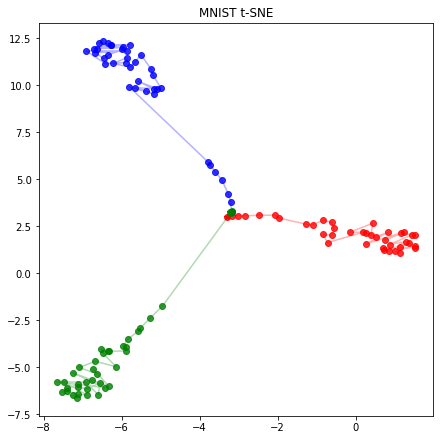

In [ ]:
# Plot
plt.figure(constrained_layout=True, figsize=(6,6))

colors_list=['r', 'b', 'g']
labels_list = ['traj_{}'.format(i) for i in range(NUM_TRAJECTORIES)]
for i in range(NUM_TRAJECTORIES):
  plt.plot(trajectory_embed[i,:,0],trajectory_embed[i,:,1],color = colors_list[i], alpha = 0.8,linestyle = "", marker = "o")
  plt.plot(trajectory_embed[i,:,0],trajectory_embed[i,:,1],color = colors_list[i], alpha = 0.3,linestyle = "-", marker = "")
  plt.plot(trajectory_embed[i,0,0],trajectory_embed[i,0,1],color = colors_list[i], alpha = 1.0,linestyle = "", marker = "*")

plt.title('MNIST t-SNE')
plt.savefig('loss_landscape_2d.png')